In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import ERFutils
from ERFutils import brewer2_light
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy.crs as ccrs
import xarray as xr
import xarrayutils

# Matplotlib definitions
matplotlib.rcdefaults()
plt.style.use('seaborn-v0_8-colorblind')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Calculate statistics and plot quantities of interest
There is frequent code duplication throughout this section so that cells could be run independently. 

Figure 1 was produced separately in Adobe Illustrator and Figure 8 is produced within notebook 4_spatial_ensemble. Figure A1 is generated using notebook 2_sens_GF.

## Figure 2a: Globally averaged Green's function for 1pctCO2

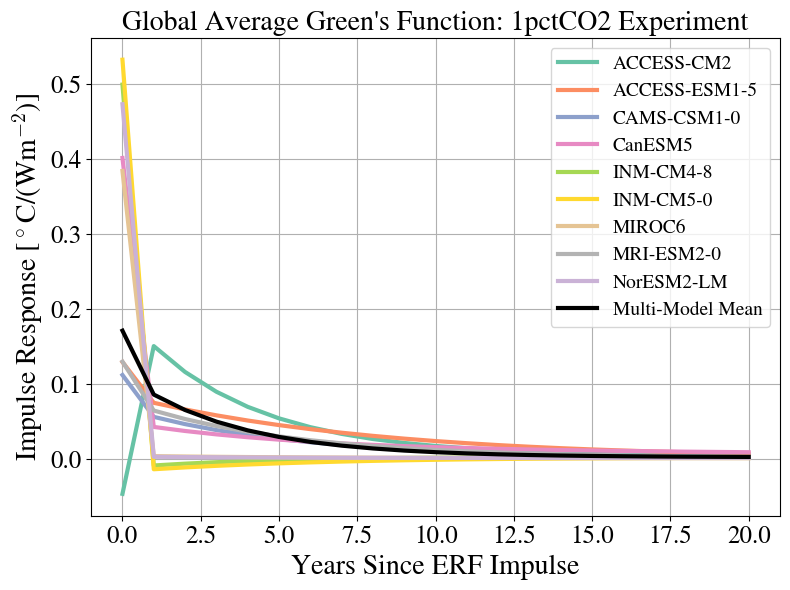

In [3]:
# Declare output paths and necesary variables
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
save_fig = False
A = ERFutils.A

# Training data id
train_id = '1pctCO2'

# Import Green's functions
G_ds_path = f'{output_path}GFs/G_{train_id}_multi_ds.nc4'
G_ds = xr.open_dataset(G_ds_path)['G[tas]']
G_ds.name = 'G'
G_ds = G_ds.sel(year = slice(0,84))

G_mean_ds_path = f'{output_path}GFs/G_{train_id}_mean_ds.nc4'
G_mean_ds = xr.open_dataset(G_mean_ds_path)['G[tas]']
G_mean_ds.name = 'G'
G_mean_ds = G_mean_ds.sel(year = slice(0,84))

time = np.arange(0,21)

# Create the figure and two subplots
fig, ax = plt.subplots(figsize = [8,6])

for i, m in enumerate(sorted(list(ERFutils.model_set))):
    response = G_ds.sel(model = m).weighted(A).mean(dim = ['lat','lon'])
    ax.plot(time, response.values[0:21], linewidth=3, color=brewer2_light(i), label=m)
    
# Plot globally averaged Green's function)
#ax.plot(G_ds.mean(dim = 'model').weighted(A).mean(dim = ['lat','lon']).values[0:21], linewidth=3, color='k', label='Multi-Model Mean')
ax.plot(G_mean_ds.weighted(A).mean(dim = ['lat','lon']).values[0:21], linewidth=3, color='k', label='Multi-Model Mean')
ax.legend(fontsize=14, loc = 'upper right')
ax.set_title(f'Global Average Green\'s Function: {train_id} Experiment',fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel('Years Since ERF Impulse',fontsize=20)
ax.set_ylabel('Impulse Response [$^\circ$C/(Wm$^{-2}$)]',fontsize=20)

ax.grid(True)

fig.tight_layout()

# Save figure as a .pdf
if save_fig:
    plt.savefig(f'{figure_path}global_multi_GF_{train_id}_final.pdf', bbox_inches = 'tight', dpi = 500)

## Figures 2b, 4a-d, 7b: Globally averaged and spatially explicit temperature emulation
Change conv_all to plot other scenarios. Create different plots with each of the functions at the end of the cell.

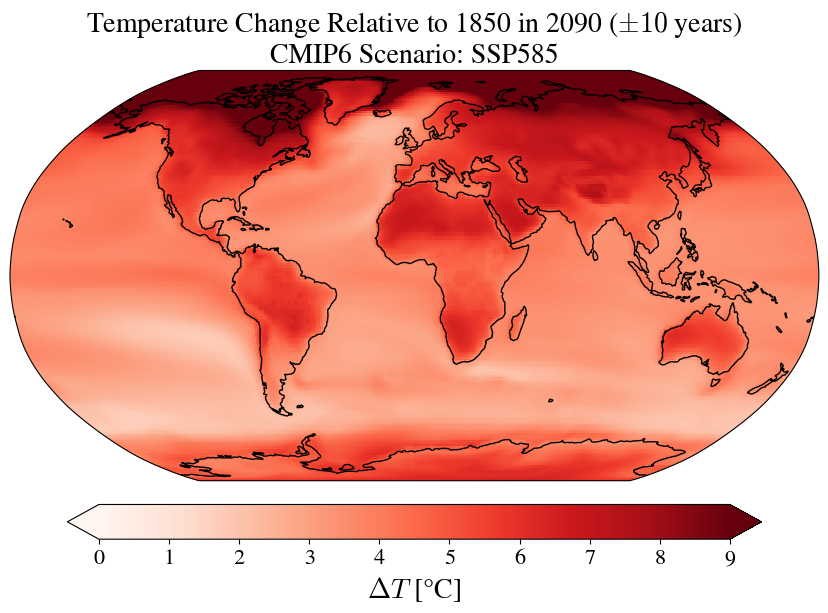

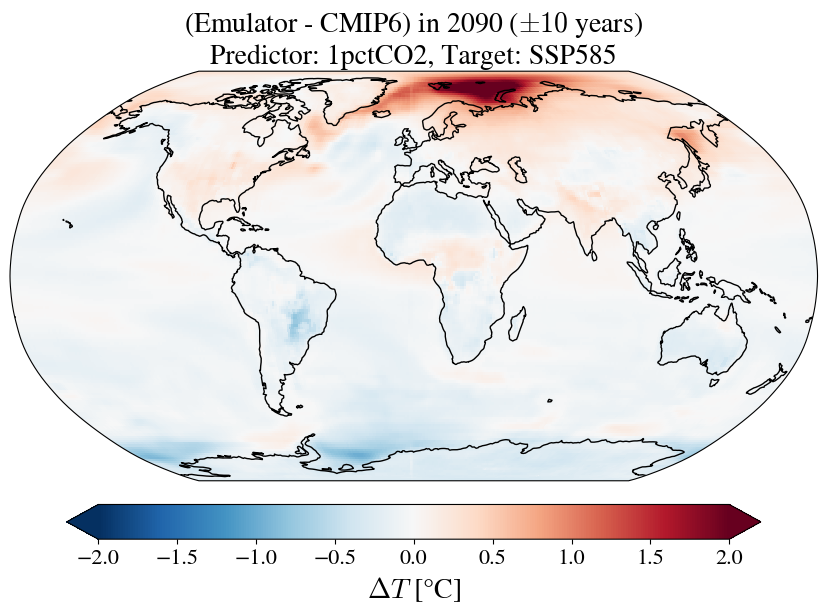

In [5]:
# Declare output paths and necesary variables
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
save_fig = False

# Training and testing datasets
train_id = '1pctCO2'
conv_all = ['ssp585']#,'ssp126','ssp245','ssp585']

# Load temperature and convolution data and plot
for conv_id in conv_all:
    tas_CMIP_path = f'{output_path}tas/tas_{conv_id}_ds.nc4'
    tas_CMIP = xr.open_dataset(tas_CMIP_path)
    
    conv_ds_path = f'{output_path}Spatial Results/res_conv_spatial_{train_id}_{conv_id}_ds.nc4'
    conv_ds = xr.open_dataset(conv_ds_path)['__xarray_dataarray_variable__']
    
    conv_mean_ds_path = f'{output_path}Global Mean Results/res_conv_global_{train_id}_{conv_id}_ds.nc4'
    conv_mean_ds = xr.open_dataset(conv_mean_ds_path)['__xarray_dataarray_variable__']

    if 'ssp' in conv_id: # SSP experiments
        start_yr1, plot_yr1, end_yr1 = 2040, 2050, 2060
        start_yr2, plot_yr2, end_yr2 = 2080, 2090, 2100
    elif 'hist' in conv_id: # Historical experiment
        start_yr, plot_yr, end_yr = 1850, 1975, 2015
    else: # 1pctCO2 experiment
        start_yr1, plot_yr1, end_yr1 = 1940, 1950, 1960
        start_yr2, plot_yr2, end_yr2 = 1980, 1990, 2000

    # Make plots
    #ERFutils.plot_conv_meanGF(train_id, conv_id, conv_mean_ds, tas_CMIP, save_fig = save_fig)
    ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr2, yr_dif = 10, train_id = train_id, conv_id = conv_id, dif = False, save_fig = save_fig)
    #ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr1, yr_dif = 10, train_id = train_id, conv_id = conv_id, save_fig = save_fig)
    ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, plot_yr = plot_yr2, yr_dif = 10, train_id = train_id, conv_id = conv_id, save_fig = save_fig)

## Figure 3a: Spatially explicit Green's functions

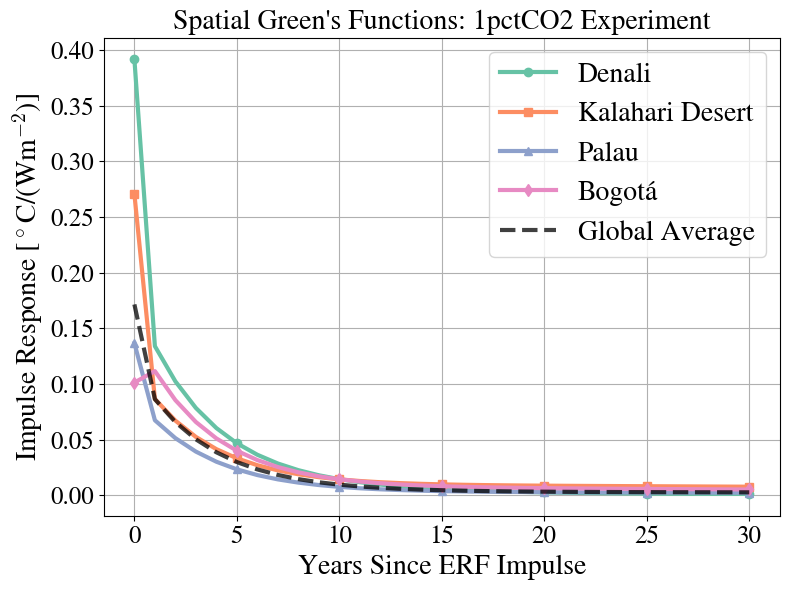

In [19]:
# Declare output paths and necesary variables
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
save_fig = False
A = ERFutils.A

# Training data id
train_id = '1pctCO2'

# Import Green's functions
G_ds_path = f'{output_path}GFs/G_{train_id}_mean_ds.nc4'
G_ds = xr.open_dataset(G_ds_path)['G[tas]']
G_ds.name = 'G'
G_ds = G_ds.sel(year  = slice(0,84))

# Define locations
lats = [63.5, -20.5, 7.5, 3.5]
lons = [210, 21, 134, 287]
locs = ['Denali','Kalahari Desert','Palau','Bogotá']

# Plot spatially explicit Green's functions with global average
fig, ax = plt.subplots(figsize = [8,6])
ax.plot(G_ds.sel(lat = lats[0], lon = lons[0]).values[0:31], linewidth=3, label=locs[0], marker='o', markevery=5, color=brewer2_light(0))
ax.plot(G_ds.sel(lat = lats[1], lon = lons[1]).values[0:31], linewidth=3, label=locs[1], marker='s', markevery=5, color=brewer2_light(1))
ax.plot(G_ds.sel(lat = lats[2], lon = lons[2]).values[0:31], linewidth=3, label=locs[2], marker='^', markevery=5, color=brewer2_light(2))
ax.plot(G_ds.sel(lat = lats[3], lon = lons[3]).values[0:31], linewidth=3, label=locs[3], marker='d', markevery=5, color=brewer2_light(3))
ax.plot(G_ds.weighted(A).mean(dim = ['lat','lon']).values[0:31], linewidth=3, alpha = 0.75, label='Global Average', color='k', linestyle='--')
ax.set_title(f'Spatial Green\'s Functions: {train_id} Experiment',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel('Years Since ERF Impulse',fontsize=20)
ax.set_ylabel('Impulse Response [$^\circ$C/(Wm$^{-2}$)]',fontsize=20)
ax.legend(fontsize=20)
plt.grid(True)
fig.tight_layout()

# Save figure as a .pdf
if save_fig:
    plt.savefig(f'{figure_path}spatial_GF_{train_id}_final.pdf', bbox_inches = 'tight', dpi = 500)

## Figure 3b: Locations of spatially explicit Green's functions
Run with previous cell to avoid missing variables.

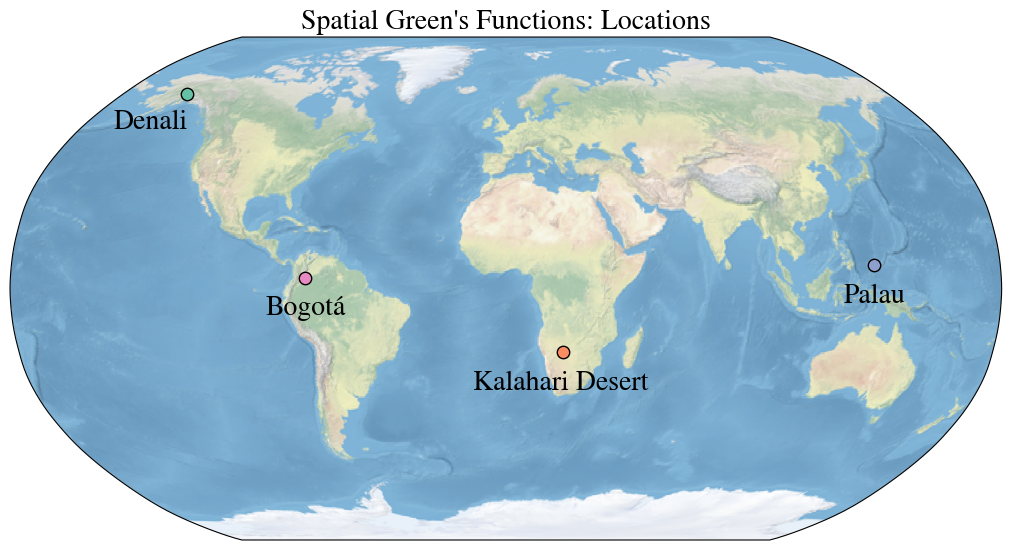

In [27]:
# Create map of the Earth using the Robinson projection
fig, ax= plt.subplots(figsize = [10,6], subplot_kw = {'projection':ccrs.Robinson()}, constrained_layout = True)
ax.stock_img()

# Add dots at each location
for i in range(len(lons)):
    plt.scatter(lons[i], lats[i], marker='o',
             transform=ccrs.Geodetic(), edgecolors='black',
             s=80, facecolors=brewer2_light(i))

# Add text to each location
plt.text(lons[0], lats[0] - 12, locs[0],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)
plt.text(lons[1], lats[1] - 12, locs[1],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)
plt.text(lons[2], lats[2] - 12, locs[2],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)
plt.text(lons[3], lats[3] - 12, locs[3],
         horizontalalignment='center',
         transform=ccrs.Geodetic(),
         fontsize = 20)
ax.set_title('Spatial Green\'s Functions: Locations',fontsize=20)

# Save figure as a .pdf
if save_fig:
    plt.savefig(f'{figure_path}spatial_GF_loc.pdf', bbox_inches = 'tight', dpi = 500)

## Figure 5: Spatial distribution of relative bias for mid- and end-of-century, Green's function only

Short Term - Predictor: 1pctCO2, Target: 1pctCO2, mean: 0.0116, std: 0.0173, max: 0.1649
Long Term - Predictor: 1pctCO2, Target: 1pctCO2, mean: -0.0004, std: 0.0037, max: 0.5415
Short Term - Predictor: 1pctCO2, Target: ssp126, mean: 0.0337, std: 0.0676, max: 0.0375
Long Term - Predictor: 1pctCO2, Target: ssp126, mean: 0.0373, std: 0.1515, max: 0.0324
Short Term - Predictor: 1pctCO2, Target: ssp245, mean: 0.0163, std: 0.0585, max: 0.0602
Long Term - Predictor: 1pctCO2, Target: ssp245, mean: 0.0083, std: 0.0414, max: 0.0649
Short Term - Predictor: 1pctCO2, Target: ssp370, mean: 0.0099, std: 0.0762, max: 0.0394
Long Term - Predictor: 1pctCO2, Target: ssp370, mean: -0.0043, std: 0.0396, max: 0.0743
Short Term - Predictor: 1pctCO2, Target: ssp585, mean: 0.0096, std: 0.0577, max: 0.0503
Long Term - Predictor: 1pctCO2, Target: ssp585, mean: -0.0085, std: 0.0364, max: 0.0816


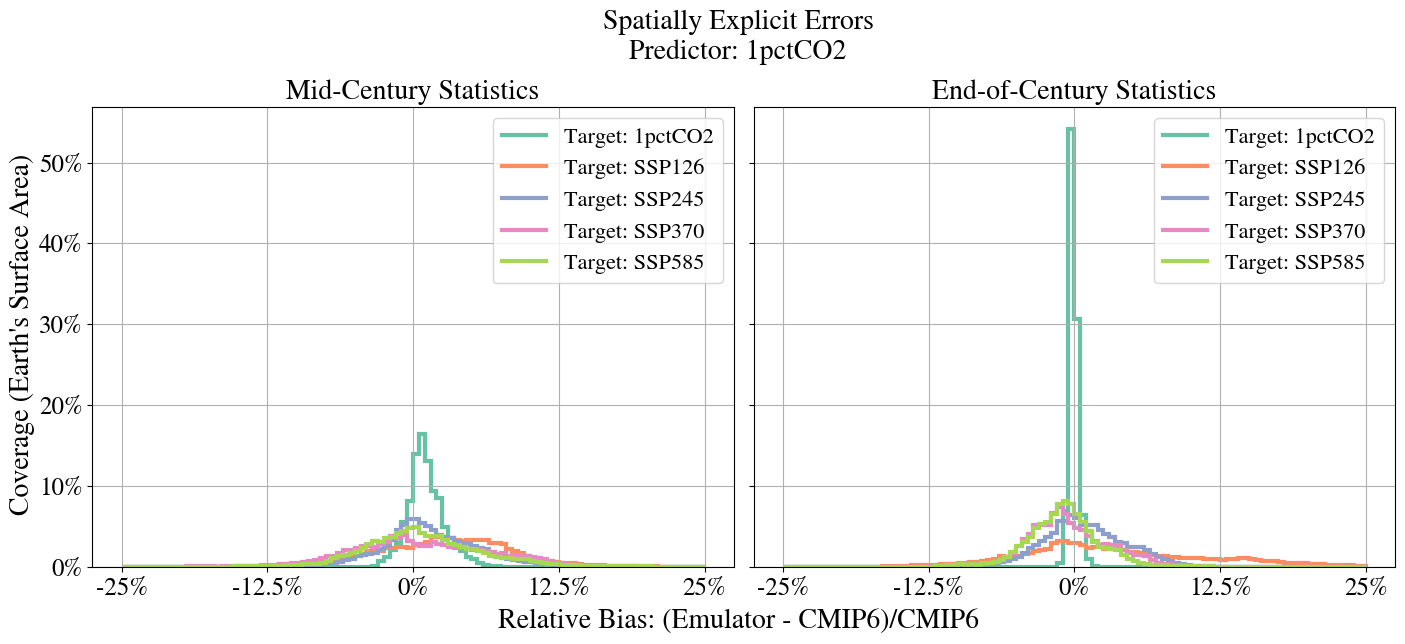

In [2]:
# Declare output paths and necesary variables
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
save_fig = False

# Training and testing datasets
train_id = '1pctCO2'
conv_all = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']

# Capital ids for plotting
conv_id_cap = {'1pctCO2':'1pctCO2',
               'ssp126':'SSP126',
               'ssp245':'SSP245',
               'ssp370':'SSP370',
               'ssp585':'SSP585'}

# Dictionaries for storing results
area_pct_short, area_pct_long = {}, {}
bins_short, bins_long = {}, {}
max_s_l = {}

for conv_id in conv_all:
    truth_path = f'{output_path}tas/tas_{conv_id}_ds.nc4'
    emulator_path = f'{output_path}Spatial Results/res_conv_spatial_{train_id}_{conv_id}_ds.nc4'

    # Define comparison years based on the experiment
    if 'ssp' in conv_id: # SSP experiments
        start_yr1, end_yr1 = 2040, 2060
        start_yr2, end_yr2 = 2080, 2100
    elif 'hist' in conv_id: # Historical experiment
        start_yr1, end_yr1 = 1900, 1940
        start_yr2, end_yr2 = 1985, 2015
    else: # 1pctCO2 experiment
        start_yr1, end_yr1 = 1940, 1960
        start_yr2, end_yr2 = 1980, 2000

    # Calculate short and long term statistics
    area_pct_short[conv_id], bins_short[conv_id], mn_short, std_short = ERFutils.calc_area_error(truth_path, emulator_path, start_yr1, end_yr1)
    area_pct_long[conv_id], bins_long[conv_id], mn_long, std_long = ERFutils.calc_area_error(truth_path, emulator_path, start_yr2, end_yr2)
    max_s_l[conv_id] = max(float(max(area_pct_short[conv_id])),float(max(area_pct_long[conv_id])))

    # Print out statistics
    print(f'Short Term - Predictor: {train_id}, Target: {conv_id}, mean: {round(float(mn_short),4)}, std: {round(float(std_short),4)}, max: {round(float(max(area_pct_short[conv_id])),4)}')
    print(f'Long Term - Predictor: {train_id}, Target: {conv_id}, mean: {round(float(mn_long),4)}, std: {round(float(std_long),4)}, max: {round(float(max(area_pct_long[conv_id])),4)}')

# Calculate maximum values over both periods for plotting axes
max_max = max([max_s_l[k] for k in max_s_l.keys()])
        
# Plot results
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,6),sharey=True)
i = 0
for conv_id in conv_all:
    ax1.stairs(area_pct_short[conv_id], bins_short[conv_id], label = f'Target: {conv_id_cap[conv_id]}', linewidth = 3, color=brewer2_light(i))
    ax2.stairs(area_pct_long[conv_id], bins_long[conv_id], label = f'Target: {conv_id_cap[conv_id]}', linewidth = 3, color=brewer2_light(i))
    i += 1
        
ax1.set_title(f'Mid-Century Statistics',fontsize=20)
ax1.set_ylim(0,max_max*1.05)
ax1.set_yticks(ticks = [0.0,0.1,0.2,0.3,0.4,0.5],labels = ['0%','10%','20%','30%','40%','50%'])
ax1.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
ax1.legend(fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.grid(True)

ax2.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
ax2.set_title(f'End-of-Century Statistics',fontsize=20)
ax2.legend(fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.grid(True)
    
fig.tight_layout(rect=[0.01, 0.03, 1, 0.95])
fig.suptitle(f'Spatially Explicit Errors\nPredictor: {train_id}',fontsize=20,y=1.04,x=0.52)
fig.supxlabel('Relative Bias: (Emulator - CMIP6)/CMIP6',fontsize=20,y=0.0,x=0.52)
fig.supylabel('Coverage (Earth\'s Surface Area)',fontsize=20,x=0.0)

# Save figure as a .pdf
if save_fig:
    plt.savefig(f'{figure_path}area_comp_conv_{train_id}.pdf', bbox_inches = 'tight', dpi = 500)


## Figure 6: Spatial distribution of relative bias for mid- and end-of-century, Green's function compared to pattern scaling

GF: Short Term - Predictor: 1pctCO2, Target: 1pctCO2, mean: 0.0116, std: 0.0173, max: 0.1649
GF: Long Term - Predictor: 1pctCO2, Target: 1pctCO2, mean: -0.0004, std: 0.0037, max: 0.5415
PS: Short Term - Predictor: 1pctCO2, Target: 1pctCO2, mean: 0.0209, std: 0.0664, max: 0.0484
PS: Long Term - Predictor: 1pctCO2, Target: 1pctCO2, mean: 0.0045, std: 0.0306, max: 0.0974


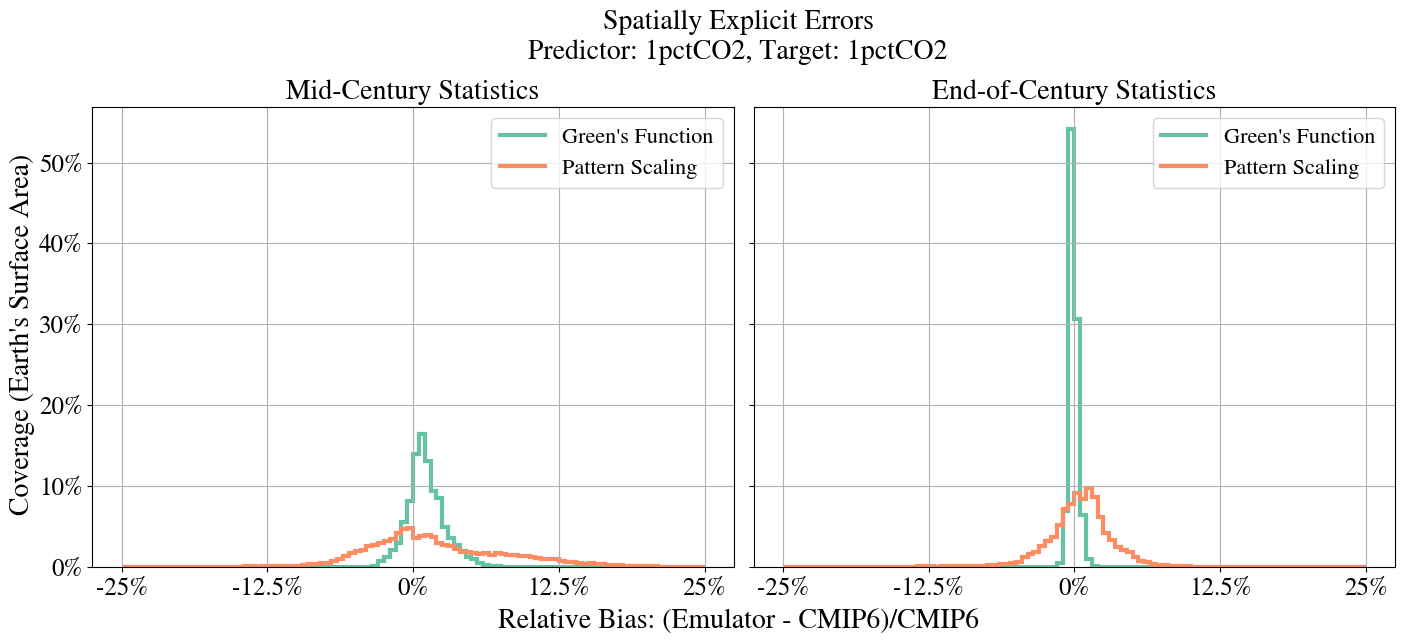

In [3]:
# Declare output paths and necesary variables
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
save_fig = True

# Training and testing datasets
train_id = '1pctCO2'
conv_all = ['1pctCO2']

# Dictionaries for storing results
area_pct_short_conv, area_pct_long_conv = {}, {}
area_pct_short_patt, area_pct_long_patt = {}, {}
bins_short_conv, bins_long_conv = {}, {}
bins_short_patt, bins_long_patt = {}, {}

# Iterate over experiments to compare
for conv_id in conv_all:
    
    # Define data paths
    truth_path = f'{output_path}tas/tas_{conv_id}_ds.nc4'
    emulator_path_conv = f'{output_path}Spatial Results/res_conv_spatial_{train_id}_{conv_id}_ds.nc4'
    emulator_path_patt = f'{output_path}Spatial Results/res_pattern_spatial_{train_id}_{conv_id}_ds.nc4'

    # Define comparison years based on the experiment
    if 'ssp' in conv_id: # SSP experiments
        start_yr1, end_yr1 = 2040, 2060
        start_yr2, end_yr2 = 2080, 2100
    elif 'hist' in conv_id: # Historical experiment
        start_yr1, end_yr1 = 1900, 1940
        start_yr2, end_yr2 = 1985, 2015
    else: # 1pctCO2 experiment
        start_yr1, end_yr1 = 1940, 1960
        start_yr2, end_yr2 = 1980, 2000
    start_yr1_patt, end_yr1_patt, start_yr2_patt, end_yr2_patt = start_yr1, end_yr1, start_yr2, end_yr2
    
    # Calculate statistics for the GFs and pattern sclaing
    area_pct_short_conv[conv_id], bins_short_conv[conv_id], mn_short_conv, std_short_conv = ERFutils.calc_area_error(truth_path, emulator_path_conv, start_yr1, end_yr1)
    area_pct_long_conv[conv_id], bins_long_conv[conv_id], mn_long_conv, std_long_conv = ERFutils.calc_area_error(truth_path, emulator_path_conv, start_yr2, end_yr2)
    area_pct_short_patt[conv_id], bins_short_patt[conv_id], mn_short_patt, std_short_patt = ERFutils.calc_area_error(truth_path, emulator_path_patt, start_yr1_patt, end_yr1_patt)
    area_pct_long_patt[conv_id], bins_long_patt[conv_id], mn_long_patt, std_long_patt = ERFutils.calc_area_error(truth_path, emulator_path_patt, start_yr2_patt, end_yr2_patt)
        
    # Print out statistics
    print(f'GF: Short Term - Predictor: {train_id}, Target: {conv_id}, mean: {round(float(mn_short_conv),4)}, std: {round(float(std_short_conv),4)}, max: {round(float(max(area_pct_short_conv[conv_id])),4)}')
    print(f'GF: Long Term - Predictor: {train_id}, Target: {conv_id}, mean: {round(float(mn_long_conv),4)}, std: {round(float(std_long_conv),4)}, max: {round(float(max(area_pct_long_conv[conv_id])),4)}')
    print(f'PS: Short Term - Predictor: {train_id}, Target: {conv_id}, mean: {round(float(mn_short_patt.tas.values),4)}, std: {round(float(std_short_patt.tas.values),4)}, max: {round(float(max(area_pct_short_patt[conv_id])),4)}')
    print(f'PS: Long Term - Predictor: {train_id}, Target: {conv_id}, mean: {round(float(mn_long_patt.tas.values),4)}, std: {round(float(std_long_patt.tas.values),4)}, max: {round(float(max(area_pct_long_patt[conv_id])),4)}')

# Calculate maximum values over both periods for plotting axes
max_s_l_conv = max(float(max(area_pct_short_conv[conv_id])),float(max(area_pct_long_conv[conv_id])))
max_s_l_patt = max(float(max(area_pct_short_patt[conv_id])),float(max(area_pct_long_patt[conv_id])))
max_max = max(max_s_l_conv, max_s_l_patt)
      
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (14,6),sharey=True)
    
# Plot results
for conv_id in conv_all:
    ax1.stairs(area_pct_short_conv[conv_id], bins_short_conv[conv_id], label = f'Green\'s Function', linewidth = 3, color=brewer2_light(0))
    ax1.stairs(area_pct_short_patt[conv_id], bins_short_patt[conv_id], label = f'Pattern Scaling', linewidth = 3, color=brewer2_light(1))
    ax2.stairs(area_pct_long_conv[conv_id], bins_long_conv[conv_id], label = f'Green\'s Function', linewidth = 3, color=brewer2_light(0))
    ax2.stairs(area_pct_long_patt[conv_id], bins_long_patt[conv_id], label = f'Pattern Scaling', linewidth = 3, color=brewer2_light(1))

    ax1.set_title(f'Mid-Century Statistics',fontsize=20)
    ax1.set_ylim(0,max_max*1.05)
    ax1.set_yticks(ticks = [0.0,0.1,0.2,0.3,0.4,0.5],labels = ['0%','10%','20%','30%','40%','50%'])
    ax1.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
    ax1.legend(fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.grid(True)

    ax2.set_xticks(ticks = [-0.25,-0.125,0,0.125,0.25],labels = ['-25%','-12.5%','0%','12.5%','25%'])
    ax2.set_title(f'End-of-Century Statistics',fontsize=20)
    ax2.legend(fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=18)
    ax2.grid(True)
    
    fig.tight_layout(rect=[0.01, 0.03, 1, 0.95])
    fig.suptitle(f'Spatially Explicit Errors\nPredictor: {train_id}, Target: {conv_id}',fontsize=20,y=1.04,x=0.52)
    fig.supxlabel('Relative Bias: (Emulator - CMIP6)/CMIP6',fontsize=20,y=0.0,x=0.52)
    fig.supylabel('Coverage (Earth\'s Surface Area)',fontsize=20,x=0.0)

# Save figure as a .pdf
if save_fig:
    plt.savefig(f'{figure_path}area_comp_conv_patt_{train_id}_{conv_id}_final.pdf', bbox_inches = 'tight', dpi = 500)
    

## Figure 7a: Fishhook plot of spatially resolved temperatures vs. global mean temperature

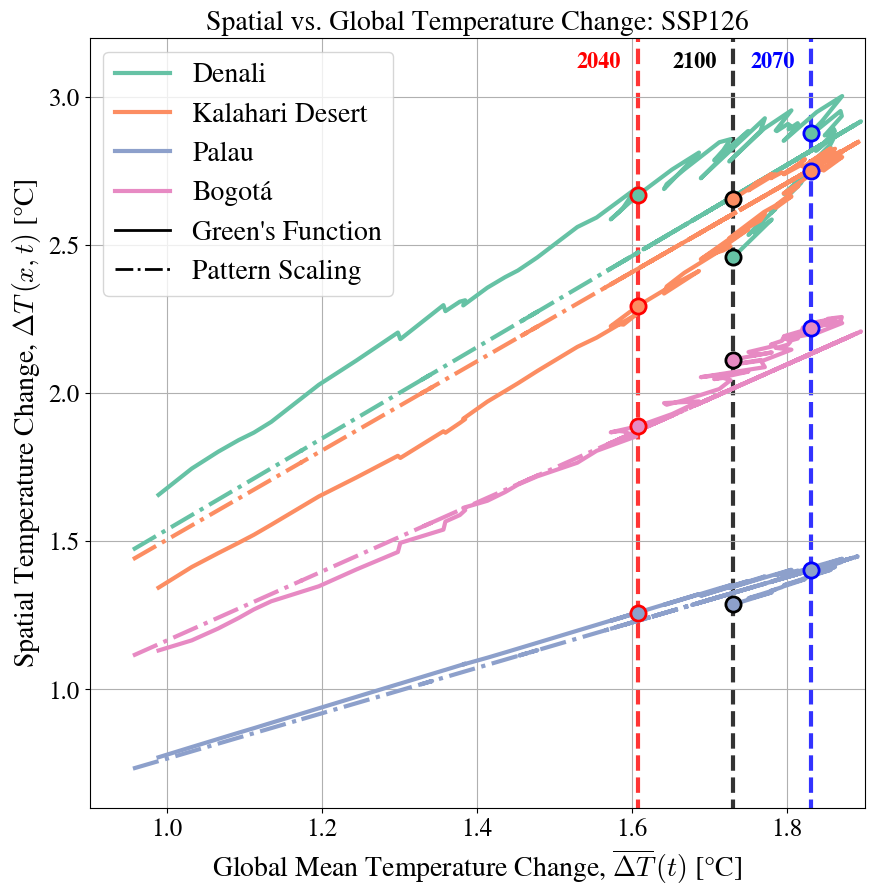

In [11]:
# Declare output paths and necesary variables
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
save_fig = False
A = ERFutils.A

# Training and testing datasets
train_id = '1pctCO2'
conv_id = 'ssp126'

# Load temperature and convolution data for GFs and pattern scaling
tas_ds_path = f'{output_path}tas/tas_{conv_id}_ds.nc4'
tas_ds = xr.open_dataset(tas_ds_path)
tas_glob_mean_ds = tas_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model'])

conv_ds_path = f'{output_path}Spatial Results/res_conv_spatial_{train_id}_{conv_id}_ds.nc4'
conv_ds = xr.open_dataset(conv_ds_path)['__xarray_dataarray_variable__']

conv_mean_ds_path = f'{output_path}Global Mean Results/res_conv_global_{train_id}_{conv_id}_ds.nc4'
conv_mean_ds = xr.open_dataset(conv_mean_ds_path)['__xarray_dataarray_variable__']

patt_ds_path = f'{output_path}Spatial Results/res_pattern_spatial_{train_id}_{conv_id}_ds.nc4'
patt_ds = xr.open_dataset(patt_ds_path)

# Define locations
lat_lon = [(63.5,210),(-20.5, 21),(7.5, 134),(3.5,287)]
locs = ['Denali','Kalahari Desert','Palau','Bogotá']

# Customize legend
legend_elements = [Line2D([0], [0], color=brewer2_light(0), lw=3, label=locs[0]),
                   Line2D([0], [0], color=brewer2_light(1), lw=3, label=locs[1]),
                   Line2D([0], [0], color=brewer2_light(2), lw=3, label=locs[2]),
                   Line2D([0], [0], color=brewer2_light(3), lw=3, label=locs[3]),
                   Line2D([0,1],[0,1],color='k', lw=2, label='Green\'s Function'),
                   Line2D([0,1],[0,1],linestyle='-.', color='k', lw=2, label = 'Pattern Scaling')]        
        

# Plot fishhook
fig, ax = plt.subplots(figsize=(10,10))
i = 0
for lat, lon in lat_lon:
    GF2040_x = conv_mean_ds.sel(s=slice(165,250)).values[0][25]
    GF2040_y = conv_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).values[0][25]
    GF2070_x = conv_mean_ds.sel(s=slice(165,250)).values[0][55]
    GF2070_y = conv_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).values[0][55]
    GF2100_x = conv_mean_ds.sel(s=slice(165,250)).values[0][84]
    GF2100_y = conv_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).values[0][84]
    
    ax.scatter(GF2040_x,GF2040_y,facecolors=brewer2_light(i),edgecolors='r',s=120,linewidths=2,zorder=3)
    ax.scatter(GF2070_x,GF2070_y,facecolors=brewer2_light(i),edgecolors='b',s=120,linewidths=2,zorder=3)
    ax.scatter(GF2100_x,GF2100_y,facecolors=brewer2_light(i),edgecolors='k',s=120,linewidths=2,zorder=3)
    
    ax.plot(conv_mean_ds.sel(s=slice(165,250)).values[0],conv_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).values[0],
            linewidth=3,color=brewer2_light(i), zorder=2)
    
    ax.plot(tas_glob_mean_ds.sel(s=slice(165,250)).tas.values,patt_ds.sel(s=slice(165,250)).sel(lat=lat,lon=lon).tas.values,
            linewidth=3,color=brewer2_light(i),linestyle='-.', zorder=2)
    
    i += 1
    
ax.vlines(GF2040_x, 0.5, 3.3, colors='r', linewidth=3,linestyles='dashed', alpha = 0.8,zorder=1)
ax.vlines(GF2070_x, 0.5, 3.3, colors='b', linewidth=3,linestyles='dashed', alpha = 0.8,zorder=1) 
ax.vlines(GF2100_x, 0.5, 3.3, colors='k', linewidth=3,linestyles='dashed', alpha = 0.8,zorder=1)  
ax.annotate('2040',(GF2040_x-0.05,3.1),fontsize=16,ha='center',weight='bold',color='r')
ax.annotate('2070',(GF2070_x-0.05,3.1),fontsize=16,ha='center',weight='bold',color='b')
ax.annotate('2100',(GF2100_x-0.05,3.1),fontsize=16,ha='center',weight='bold',color='k')
ax.set_ylim([0.6,3.2])
ax.set_xlim([0.9,1.9])

plt.grid(True)

ax.set_ylabel('Spatial Temperature Change, $\Delta T\,(x,t)$ [$\degree$C]', fontsize = 20)
ax.set_xlabel('Global Mean Temperature Change, $\overline{\Delta T}\,(t)$ [$\degree$C]', fontsize = 20)
ax.set_title(r'Spatial vs. Global Temperature Change: SSP126',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(handles=legend_elements,fontsize=20,loc='upper left')

# Save figure as a .pdf
if save_fig:
    plt.savefig(f'{figure_path}fishhook_tas_final.pdf', bbox_inches = 'tight', dpi = 500)

## Figure 9: Response function performance heatmap by scenario

	Loading 1pctCO2 experiment for convolution...
	Loading ssp126 experiment for convolution...
	Loading ssp245 experiment for convolution...
	Loading ssp370 experiment for convolution...
	Loading ssp585 experiment for convolution...
	Loading 1pctCO2 experiment for convolution...
	Loading ssp126 experiment for convolution...
	Loading ssp245 experiment for convolution...
	Loading ssp370 experiment for convolution...
	Loading ssp585 experiment for convolution...
	Loading 1pctCO2 experiment for convolution...
	Loading ssp126 experiment for convolution...
	Loading ssp245 experiment for convolution...
	Loading ssp370 experiment for convolution...
	Loading ssp585 experiment for convolution...
	Loading 1pctCO2 experiment for convolution...
	Loading ssp126 experiment for convolution...
	Loading ssp245 experiment for convolution...
	Loading ssp370 experiment for convolution...
	Loading ssp585 experiment for convolution...
	Loading 1pctCO2 experiment for convolution...
	Loading ssp126 experiment fo

/home/cwomack/BC3/ERF_Greens/ERF_Emulator/ERFutils.py:1126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


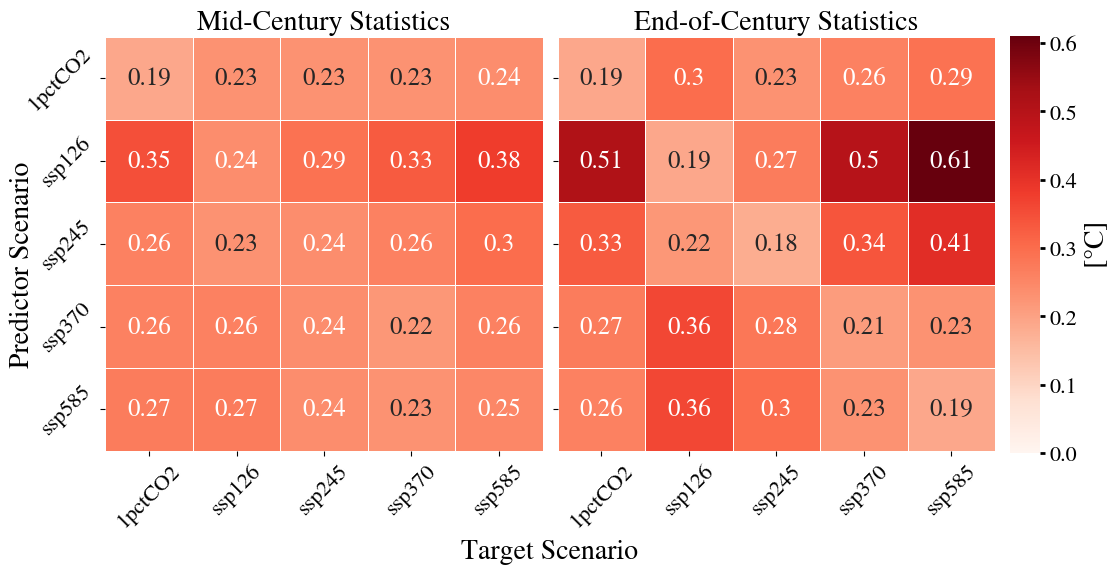

In [13]:
# Declare output paths and necesary variables
output_path = ERFutils.path_to_ERF_outputs
figure_path = ERFutils.path_to_figures
plot, save_result, save_fig = False, False, True

experiments = ['1pctCO2','ssp126','ssp245','ssp370','ssp585']

RMSE_all_short, RMSE_all_long = [], []
MAE_all_short, MAE_all_long = [], []
bias_all_short, bias_all_long = [], []
rel_bias_all_short, rel_bias_all_long = [], []

for train_id in experiments:
    # Evaluate experiments and record error statistics
    (RMSE_short, RMSE_long, MAE_short, MAE_long,
     bias_short, bias_long, rel_bias_short, rel_bias_long) = ERFutils.eval_GF(train_id, experiments, plot, save_result, save_fig, verbose=False)
    
    RMSE_all_short.append(RMSE_short)
    RMSE_all_long.append(RMSE_long)
    
    MAE_all_short.append(MAE_short)
    MAE_all_long.append(MAE_long)
    
    bias_all_short.append(bias_short)
    bias_all_long.append(bias_long)
    
    rel_bias_all_short.append(rel_bias_short)
    rel_bias_all_long.append(rel_bias_long)

ERFutils.plot_error_heatmap([RMSE_all_short, RMSE_all_long], experiments, 'RMSE', '[$\degree$C]', save_fig)
#ERFutils.plot_error_heatmap([MAE_all_short, MAE_all_long], experiments, 'MAE', '[$\degree$C]', save_fig)
#ERFutils.plot_error_heatmap([bias_all_short, bias_all_long], experiments, 'Bias', '[$\degree$C]', save_fig)
#ERFutils.plot_error_heatmap([rel_bias_all_short, rel_bias_all_long], experiments,'Relative Bias', '%', save_fig)